## Make Allan Deviation Plot

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from andbro__querrySeismoData import __querrySeismoData
from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## Configurations

config = {}

config['datatype'] = "beat" ## raw | rotation_rate | beat

config['tbeg'] = obs.UTCDateTime("2023-09-19 05:30")
config['tend'] = obs.UTCDateTime("2023-09-19 08:30")

# config['seed'] = "BW.ROMY.10.BJZ"
config['seed'] = "BW.ROMY..BJU"

config['repository'] = "archive"

config['output_figures'] = data_path+"allan_deviation/"

config['net'], config['sta'], config['loc'], config['cha'] = config['seed'].split(".")

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['sagnac_rings'] = {"Z":553.5, "U":303.05, "V":447, "W":447}
config['nominal_sagnac'] = config['sagnac_rings'][config['seed'][-1]]

## ALLAN

## show error bars
config['errorbars'] = True

## plot rotation rate relative to 2pi/86400
config['relative'] = False

## tau intervale
config['tau'] = 'all' ## all, octave, decade

## type of allan deviation
config['method'] = 'adev' ## adev, oadev, mdev

## phase or frequency
config['intype'] = "freq"

## Load Data

### import raw sagnac data

In [4]:
if config['datatype'] == "raw":

    st = __read_sds(archive_path+"romy_archive", "BW.DROMY..FJZ", config['tbeg'], config['tend'])

    for tr in st:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

        ## convert from Hz to rad/s with scale factor
        # tr.data = tr.data/10182093.88

    st

### import sagnac frequency

In [5]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

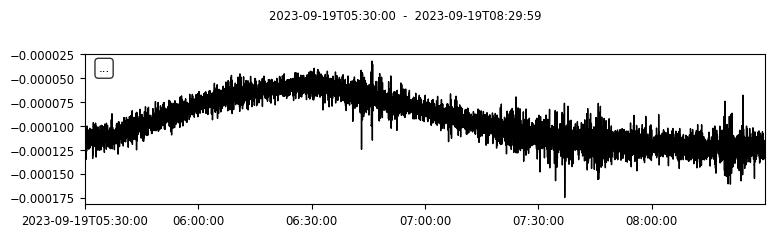

In [6]:
if config['datatype'] == "beat":

    data = __load_beat(config['tbeg'], config['tend'], config['cha'][2], config['path_to_autodata'])

    tr = obs.Trace()
    tr.data = np.array(data.fj)
    tr.stats.delta = 1.0
    tr.stats.starttime = obs.UTCDateTime(config['tbeg'])
    st = obs.Stream(tr)

    st[0].data = (st[0].data - config['nominal_sagnac']) / config['nominal_sagnac']

    ## convert from Hz to rad/s with scale factor
    # tr.data = tr.data/10182093.88

    st.plot();

### import rotation rate data

In [7]:
if config['datatype'] == "rotation_rate":

    st = __read_sds(config['path_to_sds'], config['seed'], config['tbeg']-10, config['tend']+10)

    inv = obs.read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless.seed.BW_ROMY")

    st.detrend("demean");

    st.remove_sensitivity(inv);

    st.trim(config['tbeg'], config['tend']);

    ## convert from Hz to rad/s with scale factor
    st[0].data = st[0].data * 10182093.88 * 2*np.pi/86400

    st.plot();

## Compute Allan Dev

In [8]:
## define tau range e.g. 5 (= 10⁵) and number of samples N
upper = 6
lower = -4
N = 150

## list of tau values in seconds
taux = np.logspace(lower, upper, N)

## smallest sampling in seconds
dtaux = taux[1]-taux[0]

## sampling rate
df = st[0].stats.sampling_rate

In [9]:
# allan = allantools.tdev( st[0].data,
#                          data_type='freq',
#                          rate=df,
#                          taus=config['tau']
#                         )

In [10]:
## normal allan deviation
## allan = (taus1, adevs1, errors, ns)

if config['method'] == "oadev":
    allan = allantools.oadev(st[0].data,
                             data_type=config['intype'],
                             rate=df,
                             taus=config['tau'],
                             )

elif config['method'] == "mdev":
    allan = allantools.mdev(st[0].data,
                            data_type=config['intype'],
                            rate=df,
                            taus=config['tau'],
                            )

elif config['method'] == "adev":
    allan = allantools.adev(st[0].data,
                            data_type=config['intype'],
                            rate=df,
                            taus=config['tau'],
                            )

## Plotting

In [11]:
def __makeplot_allan_deviation(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  

    if config['relative']:
        adev = adev / 7.3e-5

    ## -------------------------------------------
    fig, ax = plt.subplots(1,1, figsize=(12,8))

    font = 14


    if config['errorbars']:
        ax.scatter(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=2)
        ax.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
    else:
        ax.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")


    ax.set_title(f"Allan Deviation for {config['net']}.{config['cha']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax.set_xlabel(r"$\tau$ [s]", fontsize=font)

    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();

# __makeplot_allan_deviation(config, st, allan)

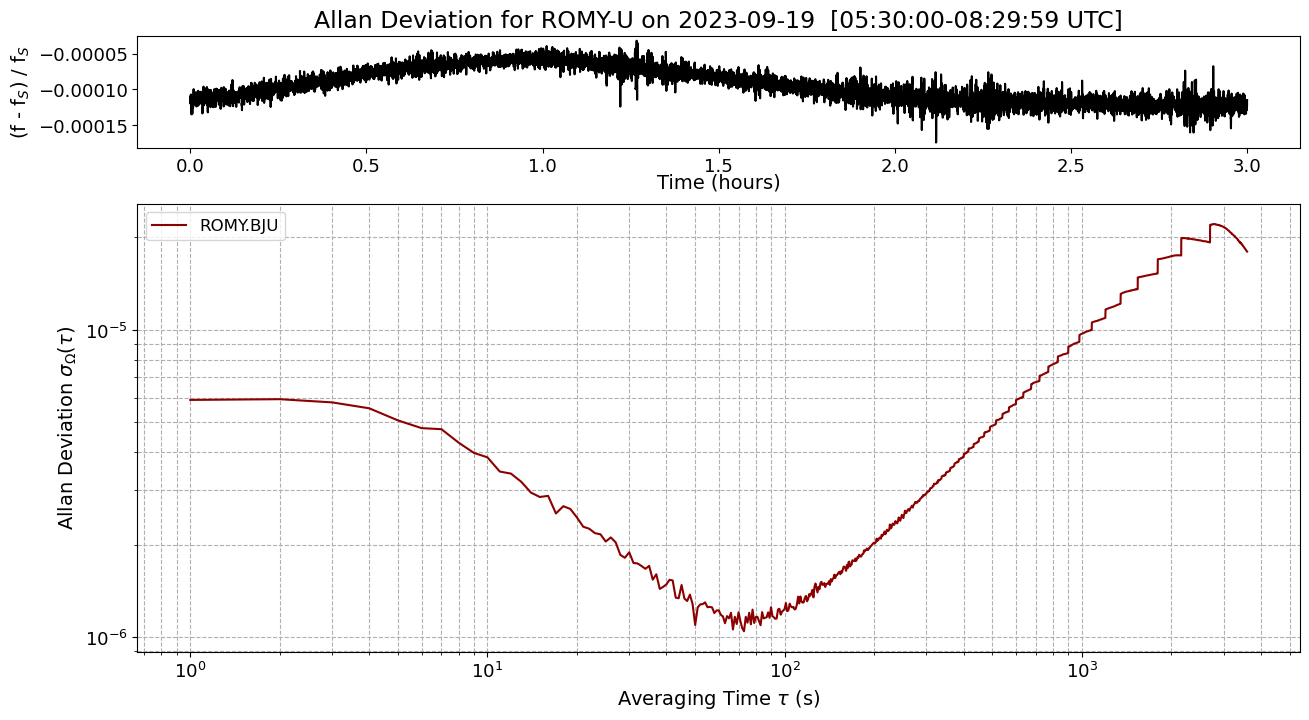

In [12]:
def __makeplot_allan_deviation2(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  

    if config['relative']:
        adev = adev / 7.3e-5

    ## -------------------------------------------
    fig = plt.figure(constrained_layout=False, figsize=(15,8))

    widths = [1]
    heights = [1/5,4/5]

    spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.2, wspace=0.02)

    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])

    font = 14

    # --------------------
    ax1.plot(st[0].times()/3600, st[0].data, 'k')

    ax1.set_title(f"Allan Deviation for {config['sta']}-{config['seed'][-1]} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax1.set_xlabel(f"Time (hours)", fontsize=font, labelpad=-2)

    if config['datatype'] == "beat":
        ax1.set_ylabel("(f - f$_{S}$) / f$_{S}$", fontsize=font)
    elif config['datatype'] == "rotation_rate":
        ax1.set_ylabel(f"$\Omega$ (rad/s)", fontsize=font)
    elif config['datatype'] == "raw":
        ax1.set_ylabel(f"A (V)", fontsize=font)

    ax1.ticklabel_format(useOffset=False)


    ax1.tick_params(labelsize=font-1)

    # --------------------
    if config['errorbars']:
        ax2.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=3)
        # ax2.scatter(taus, adev, color='white', edgecolor="darkred", lw=2, label=f"{config['sta']}.{config['cha']}", zorder=3)
        # ax2.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=2)
    else:
        ax2.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")


    ax2.set_xlabel(r"Averaging Time $\tau$ (s)", fontsize=font)

    add = ""
    if config['method'] == "oadev":
        add = "Overlapping "

    sigma_tau = r"$\sigma_{\Omega} (\tau)$"

    if config['relative']:
        ax2.set_ylabel(f"{add}Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        if config['datatype'] == "beat":
            ax2.set_ylabel(f"{add}Allan Deviation {sigma_tau}", fontsize=font)
        elif config['datatype'] == "raw":
            ax2.set_ylabel(f"{add}Allan Deviation {sigma_tau} (V)", fontsize=font)
        elif config['datatype'] == "rotation_rate":
            ax2.set_ylabel(f"{add}Allan Deviation {sigma_tau} (rad/s)", fontsize=font)

    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax2.legend(fontsize=font-2)

    ax2.grid(True, which="both", ls="--")

    ax2.tick_params(labelsize=font-1)

    plt.show();
    return fig

fig = __makeplot_allan_deviation2(config, st, allan)

# fig.savefig(config['output_figures']+f"{config['sta']}_{config['cha']}_allan_{config['tbeg'].date}_{config['datatype']}.jpeg", format="jpeg", dpi=150, bbox_inches='tight')